This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-04-03
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 0.75, 'contrast': 0.5, 'sf_0': 0.2, 'B_sf': 0.08, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 382, 'dim2': 618, 'lr': 0.005, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.3, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-04-03', 'seed': 2019, 'N_cv': 2, 'do_compute': True}
Overwriting train.py
2019-04-03T12:23:16+02:00

CPython 3.7.2
IPython 7.4.0

numpy 1.16.2
matplotlib 3.0.3
torch 1.0.1.post2

compiler   : Clang 10.0.0 (c

In [2]:
figname = '../paper/fig_params'

In [3]:
%%writefile params.py
import os
import torch
from main import init, MetaML
from where import Where as ML
from what import WhatNet
import numpy as np        
import sys
opts = dict(filename='../data/2019-03-30', verbose=0, log_interval=0, do_compute=False  if len(sys.argv) > 1 else True)
#opts = dict(filename='debug', verbose=0, log_interval=0)
print('do_compute =', opts['do_compute'])

print(50*'-')
print(' parameter scan')
print(50*'-')

if opts['do_compute']:
    args = init(**opts)
    #args.filename = '../data/2019-03-27'
    filename_train = args.filename + '_train.pt'
    if not(os.path.isfile(filename_train + '_lock')):
        open(filename_train + '_lock', 'w').close()
        print(50*'-')
        print('Default parameters')
        print(50*'-')
        from where import Where as ML
        from what import WhatNet
        ml = ML(args)
        ml.train(path=filename_train)
        # ml.main(path=args.filename)
        try:
            os.remove(filename_train + '_lock')
        except:
            pass

if True:
    args = init(**opts)
    mml = MetaML(args)
    if torch.cuda.is_available():
        mml.scan('no_cuda', [True, False])

    args = init(**opts)
    mml = MetaML(args)
    mml.scan('bias_deconv', [True, False])

results = {}
    
def update_results(results, parameter, accuracies, ci=0.01):
    from scipy.stats import beta

    if not parameter in results.keys(): results[parameter] = dict(value=[], accuracy=[], p_low=[], p_sup=[])
    for value in accuracies.keys():
        results[parameter]['value'].append(value)
        results[parameter]['accuracy'].append(accuracies[value][:-1].mean()*100)
        try:
            a1, b1, loc1, scale1 = beta.fit(accuracies[value][:-1], floc=0, fscale=1)
            p_low, p_sup = beta.ppf([ci, 1-ci], a=a1, b=b1)
            #print(p_low, p_sup)
            results[parameter]['p_low'].append(p_low*100)
            results[parameter]['p_sup'].append(p_sup*100)
        except:
            results[parameter]['p_low'].append(accuracies[value][:-1].mean()*100)
            results[parameter]['p_sup'].append(accuracies[value][:-1].mean()*100)
        
    return results
            
bases = [2]
#bases = [np.sqrt(2), 2, 2*np.sqrt(2)]    
for base in bases if not args.filename == '../data/debug' else [2]:
    print(50*'-')
    print(' base=', base)
    print(50*'-')

    print(50*'-')
    print(' parameter scan : data')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args, base=base)
    for parameter in ['sf_0', 'B_sf', 'offset_std' , 'noise', 'contrast']: #
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        
    print(50*'-')
    print(' parameter scan : network')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['dim1',
                      'bn1_bn_momentum',
                      'dim2',
                      'bn2_bn_momentum',
                      'p_dropout']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(' parameter scan : learning ')
    args = init(**opts)
    mml = MetaML(args, base=base, tag='SGD')
    print(50*'-')
    print('Using SGD')
    print(50*'-')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter + '_sgd', accuracies)
    print(50*'-')
    print('Using ADAM')
    print(50*'-')
    args = init(**opts)
    args.do_adam = True
    mml = MetaML(args, base=base, tag='adam')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter + '_adam', accuracies)

    print(50*'-')
    print(' parameter scan : retina')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['N_theta',
                      'N_azimuth',
                      'N_eccentricity',
                      'rho']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        

Overwriting params.py


In [4]:
%run params.py scan

do_compute = False
--------------------------------------------------
 parameter scan
--------------------------------------------------
scanning over bias_deconv = [True, False]
For parameter bias_deconv = True ,  Accuracy=72.2% +/- 0.0%  in 4115.3 seconds
For parameter bias_deconv = False ,  Accuracy=72.2% +/- 0.0%  in 4123.4 seconds
--------------------------------------------------
 base= 2
--------------------------------------------------
--------------------------------------------------
 parameter scan : data
--------------------------------------------------
scanning over sf_0 = [0.1        0.1259921  0.15874011 0.2        0.25198421 0.31748021
 0.4       ]
For parameter sf_0 = 0.100 ,  Accuracy=57.2% +/- 0.9%  in 6755.1 seconds
For parameter sf_0 = 0.126 ,  Accuracy=63.4% +/- 0.4%  in 6695.6 seconds
For parameter sf_0 = 0.159 ,  Accuracy=67.9% +/- 0.4%  in 6574.6 seconds
For parameter sf_0 = 0.200 ,  Accuracy=72.2% +/- 0.0%  in 4148.1 seconds
For parameter sf_0 = 0.252 ,  Acc

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  fac = xbar * (1 - xbar) / data.var(ddof=0) - 1
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:452: RuntimeWarning: invalid value encountered in double_scalars
  func = [s1 - n * (-psiab + sc.psi(a)),
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:453: RuntimeWarning: invalid value encountered in double_scalars
  s2 - n * (-psiab + sc.psi(b))]


scanning over B_sf = [0.04       0.05039684 0.06349604 0.08       0.10079368 0.12699208
 0.16      ]
For parameter B_sf = 0.040 ,  Accuracy=72.1% +/- 0.3%  in 6443.7 seconds
For parameter B_sf = 0.050 ,  Accuracy=72.9% +/- 0.0%  in 6436.5 seconds
For parameter B_sf = 0.063 ,  Accuracy=71.7% +/- 0.3%  in 5915.7 seconds
For parameter B_sf = 0.080 ,  Accuracy=72.2% +/- 0.0%  in 3068.1 seconds
For parameter B_sf = 0.101 ,  Accuracy=71.3% +/- 0.8%  in 5962.4 seconds
For parameter B_sf = 0.127 ,  Accuracy=71.4% +/- 0.2%  in 6686.8 seconds
For parameter B_sf = 0.160 ,  Accuracy=71.7% +/- 0.4%  in 6753.8 seconds
scanning over offset_std = [15, 18, 23, 30, 37, 47, 60]
For parameter offset_std = 15 ,  Accuracy=78.9% +/- 0.3%  in 6849.6 seconds
For parameter offset_std = 18 ,  Accuracy=77.4% +/- 0.1%  in 6781.3 seconds
For parameter offset_std = 23 ,  Accuracy=74.6% +/- 1.2%  in 6729.4 seconds
For parameter offset_std = 30 ,  Accuracy=72.2% +/- 0.0%  in 4253.2 seconds
For parameter offset_std = 3

## parameter scan

In [5]:
def plot_accuracy(result, xmin=10, fig=None, ax=None, ylabel=None):
    if fig is None: fig, ax = plt.subplots(figsize=(5, 5))
    #ax.plot(result['accuracy'], result['value'], "o", color='blue')
    # print(value, accuracy)
    ax.hlines(y=result['value'], xmin=result['accuracy'], xmax=100, color='red')
    ax.hlines(y=result['value'], xmin=xmin, xmax=result['accuracy'], color='skyblue')
    ax.hlines(y=result['value'], xmin=result['p_low'], xmax=result['p_sup'], color='blue', alpha=1., lw=7)

    if ylabel is None:
        ylabel = parameter.capitalize()
    ax.set_ylabel(ylabel)
    #print( results[parameter]['value'] )
    #print( np.min([np.float(k) for k in results[parameter]['value']]))
    #ax.vlines(100, np.min(results[parameter]['value']), np.max(results[parameter]['value']), 'k', label='max')
    ax.set_xlabel('Accuracy (%)')
    # Only draw spine between the y-ticks
    #ax.spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return fig, ax

---> sf_0


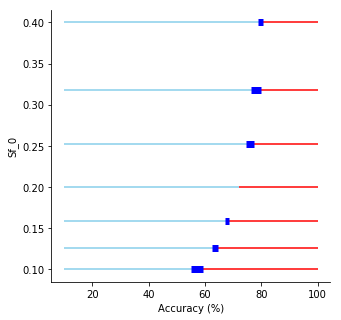

---> B_sf


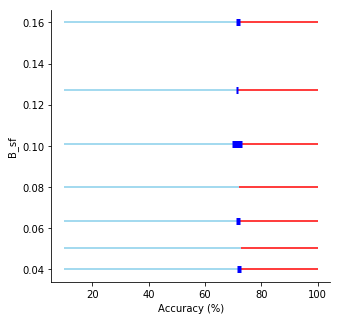

---> offset_std


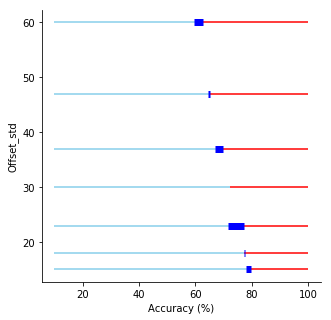

---> noise


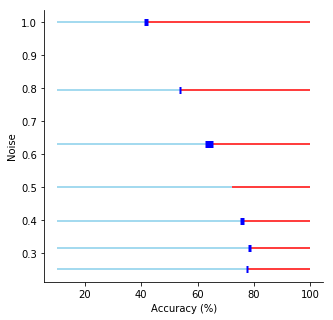

---> contrast


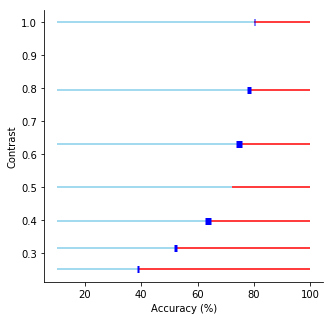

---> dim1


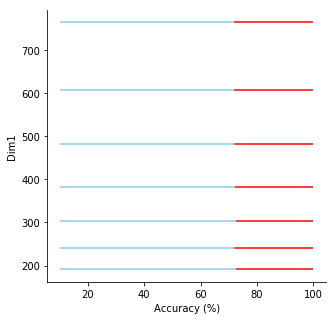

---> bn1_bn_momentum


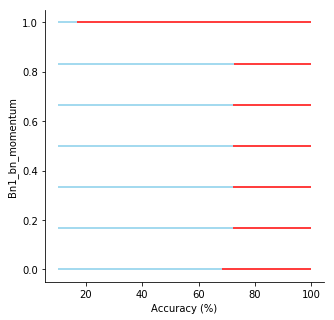

---> dim2


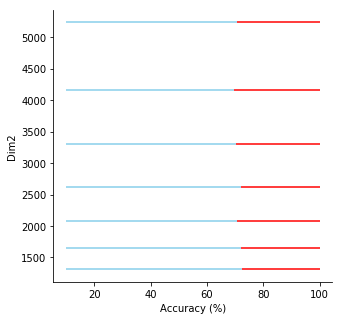

---> bn2_bn_momentum


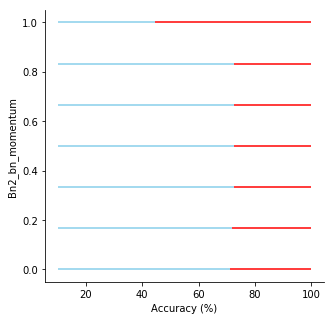

---> p_dropout


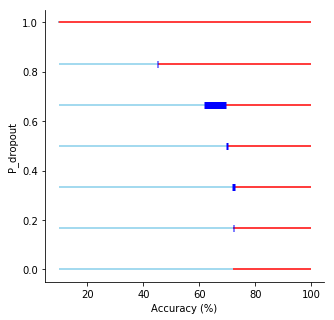

---> lr_sgd


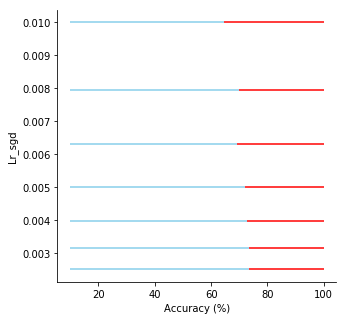

---> momentum_sgd


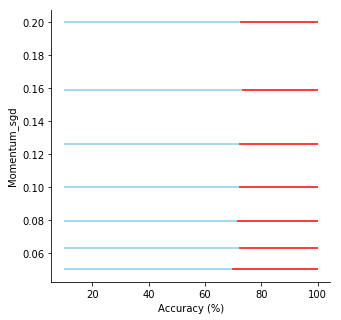

---> minibatch_size_sgd


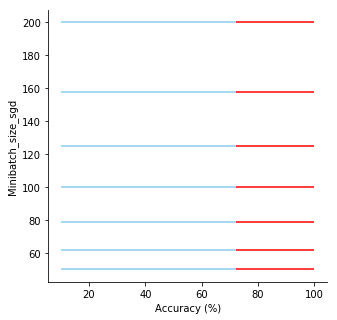

---> epochs_sgd


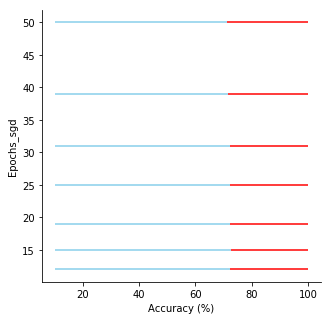

---> lr_adam


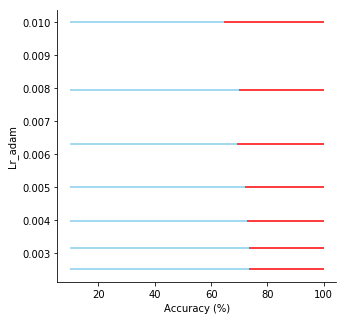

---> momentum_adam


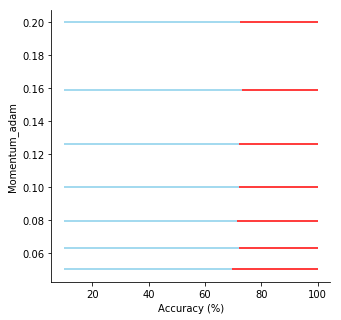

---> minibatch_size_adam


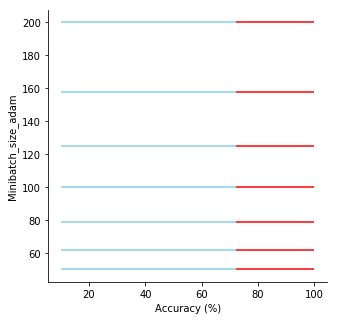

---> epochs_adam


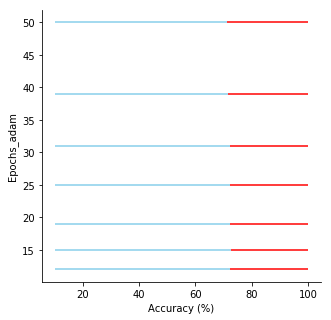

---> N_theta


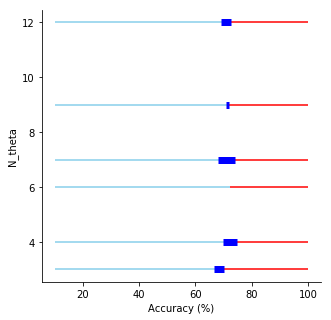

---> N_azimuth


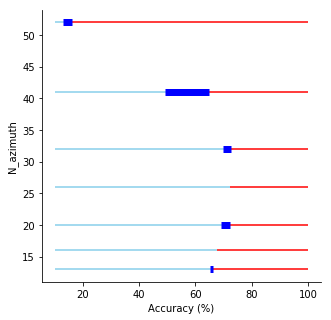

---> N_eccentricity


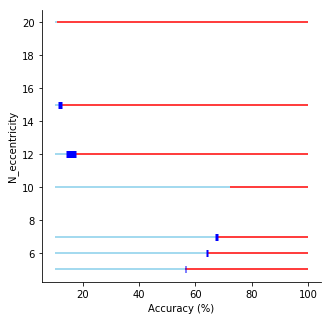

---> rho


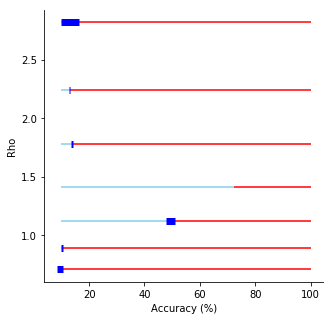

In [6]:
figname_ = 'accuracy_'
figname_ = ''

tex = ''
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plot_accuracy(results[parameter])
    plt.show()
    if not figname_ == '':
        fig_dir = './'
        fig_ext = '.pdf'
        fname = figname_ + parameter + fig_ext
        tex += "\includegraphics[width=.0666\linewidth]{"+ fname + "} \n"
        fig.savefig(os.path.join(fig_dir, fname),
                bbox_inches='tight', pad_inches=0)
print(tex)

# summary


In [7]:
results.keys()

dict_keys(['sf_0', 'B_sf', 'offset_std', 'noise', 'contrast', 'dim1', 'bn1_bn_momentum', 'dim2', 'bn2_bn_momentum', 'p_dropout', 'lr_sgd', 'momentum_sgd', 'minibatch_size_sgd', 'epochs_sgd', 'lr_adam', 'momentum_adam', 'minibatch_size_adam', 'epochs_adam', 'N_theta', 'N_azimuth', 'N_eccentricity', 'rho'])

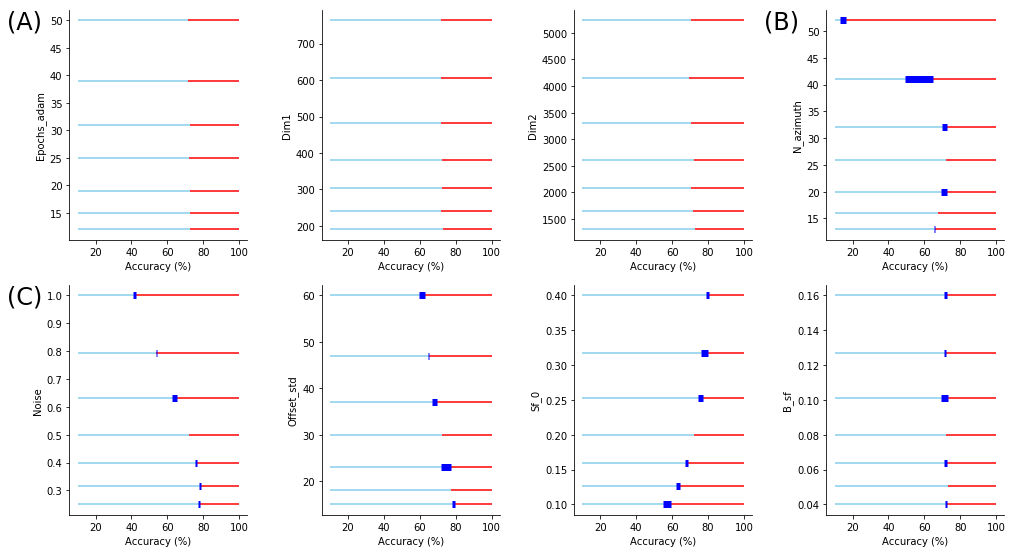

In [8]:
parameters = [['epochs_adam', 'dim1', 'dim2', 'N_azimuth'],
              ['noise', 'offset_std', 'sf_0', 'B_sf']]  # '', 'lr', 
fig, axs = plt.subplots(len(parameters), len(parameters[0]), figsize = (figwidth, figwidth/len(parameters)*1.1), subplot_kw={})

for i_row, parameters_ in enumerate(parameters):
    for ax, parameter in zip(axs[i_row], parameters_):
        fig, ax = plot_accuracy(results[parameter], xmin=10, fig=fig, ax=ax)

for ax, text, x_offset, y_offset in [[axs[0][0], 'A', -.35, .95], [axs[0][-1], 'B', -.35, .95], [axs[1][0], 'C', -.35, .95]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 
        
plt.tight_layout()
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.05)

# post-processing

In [9]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

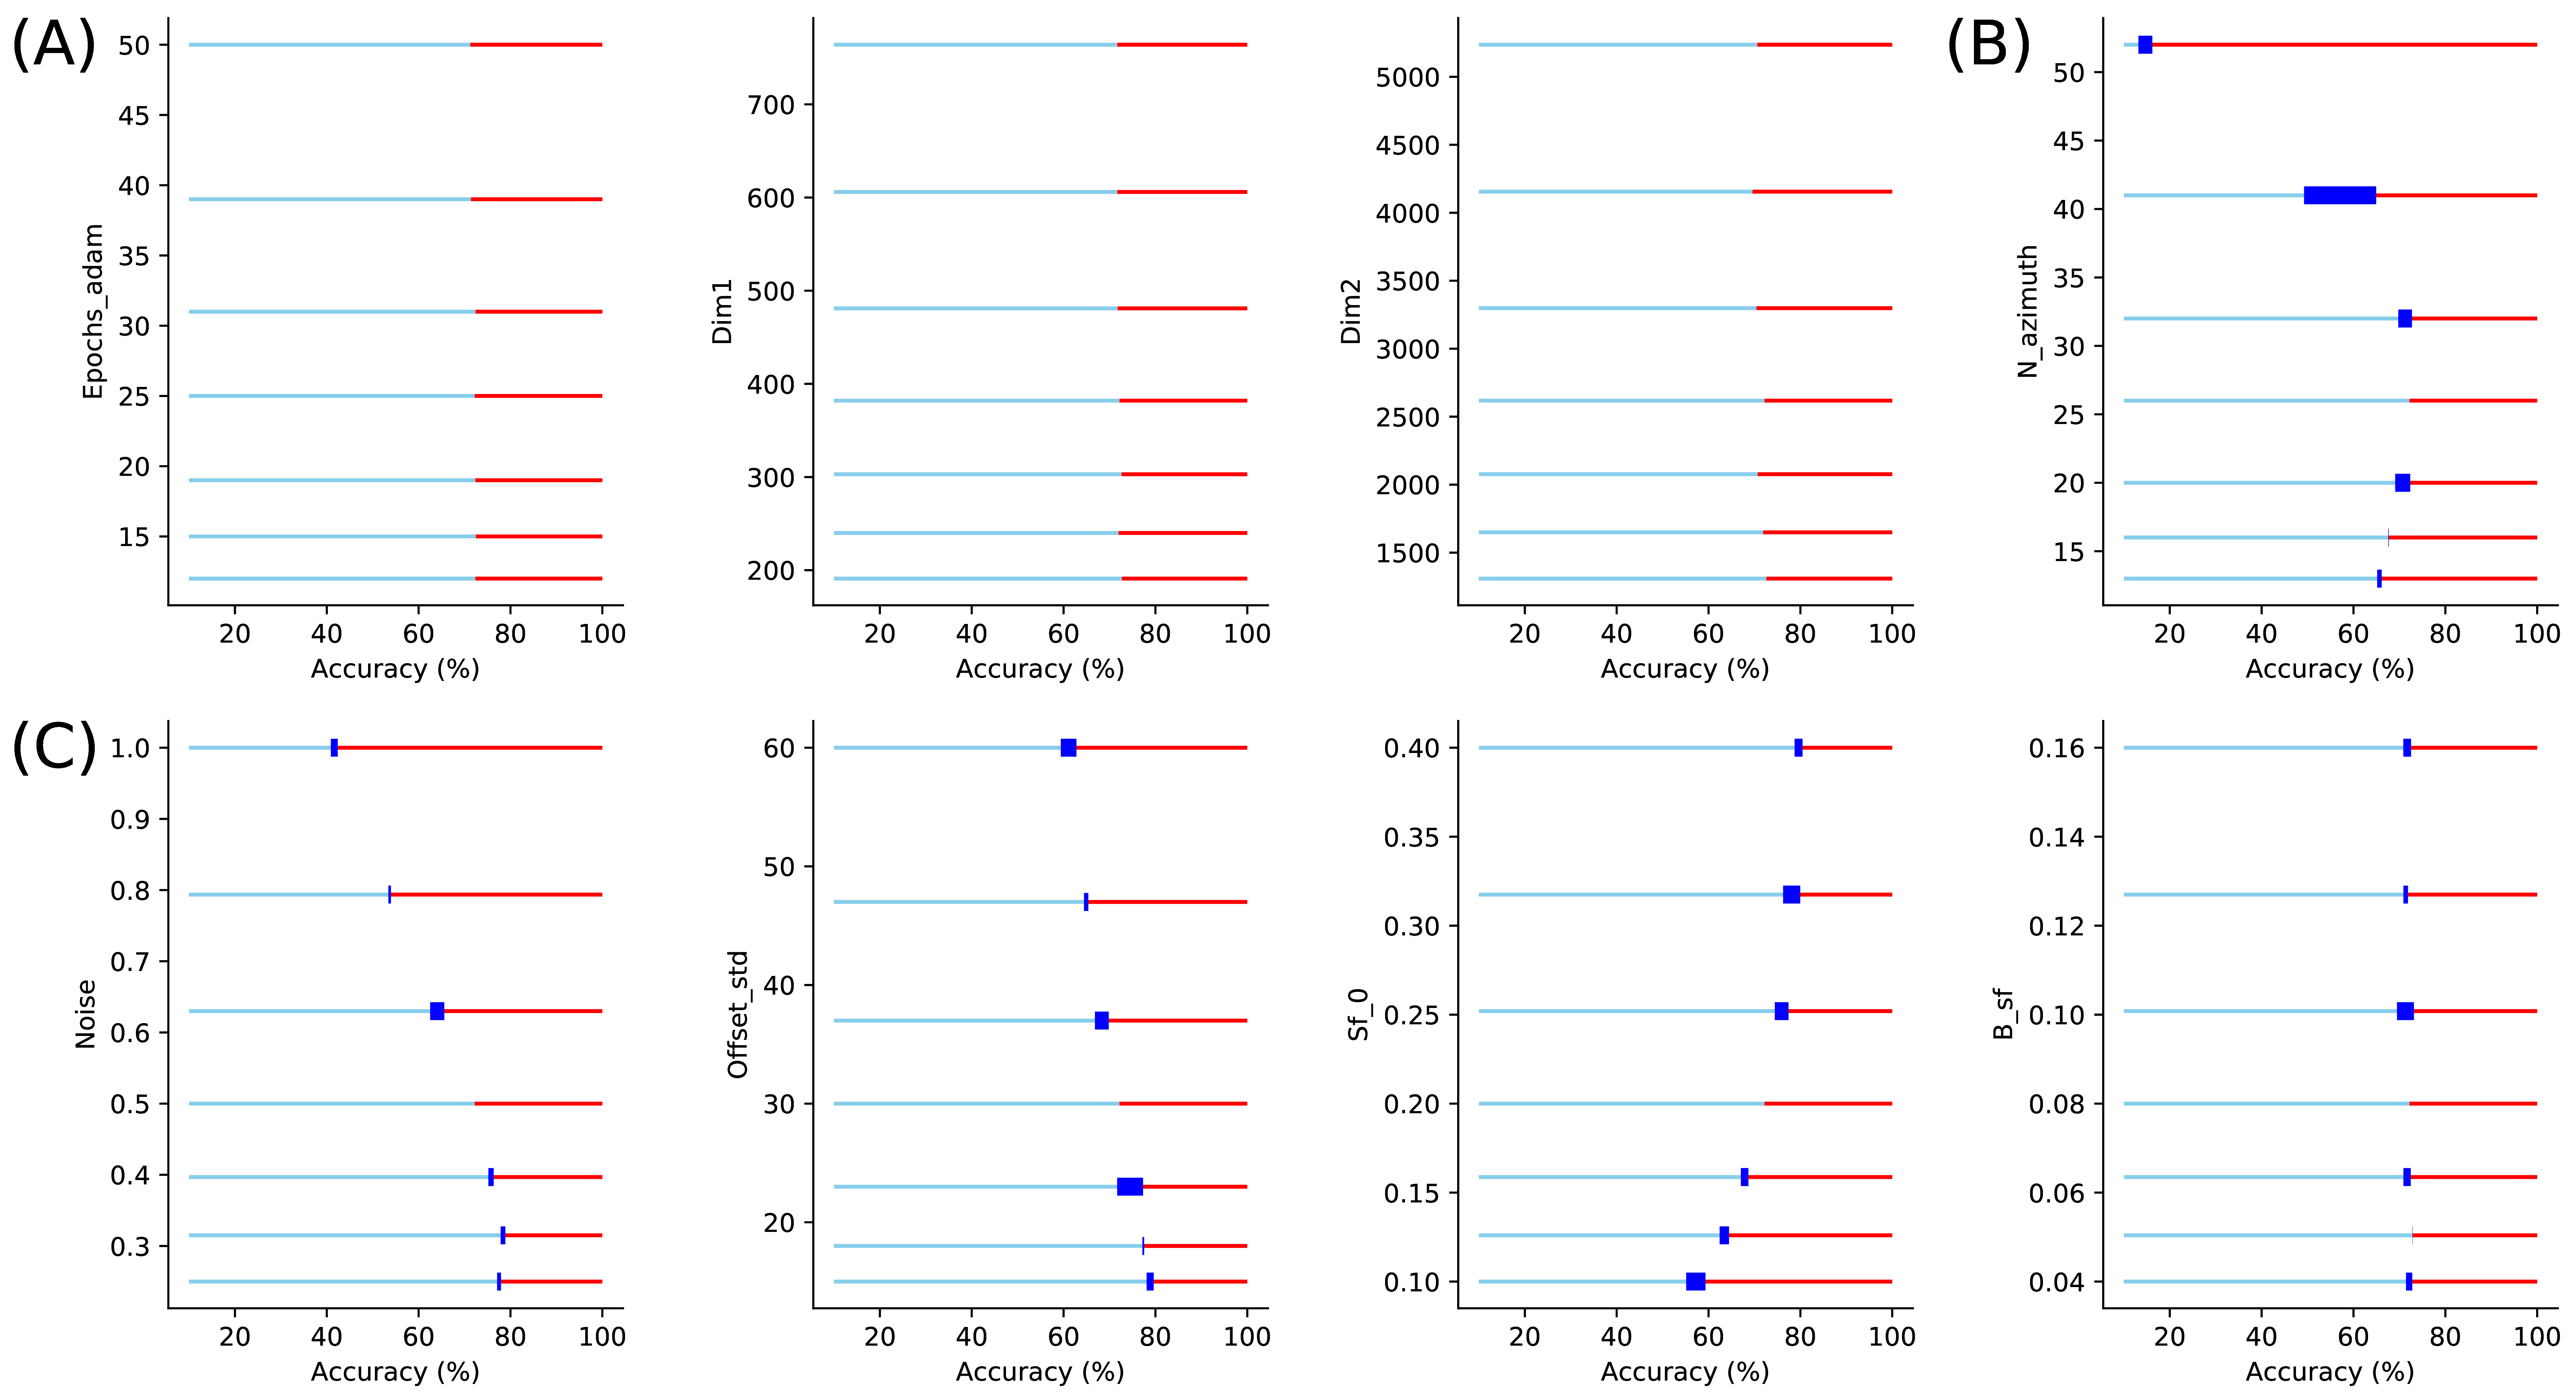

In [10]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [11]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  1571977 Apr  3 12:23 ../paper/fig_params.jpg
-rw-r--r--  1 laurentperrinet  staff    20023 Apr  3 12:23 ../paper/fig_params.pdf
-rw-r--r--  1 laurentperrinet  staff   185914 Apr  3 12:23 ../paper/fig_params.png
